# Introduction

<p align="justify">Welcome! In this case we'll be exploring how to use advanced analytic and machine learning techniques to predict high risk asthmatic patients. 

<br>
<br>
<details>
<summary>Some of the skills you'll explore are (Click to Expand):</summary>
<ul>
    <li>R Programming</li>
    <li>Data Cleaning</li>
    <li>Descriptive Analysis</li>
    <li>Data Visualization</li>
    <li>Leveraging Domain Knowledge</li>
    <li>Logistic Regression</li>
    <li>Machine Learning</li>
</details><br>

Don't worry if you're unsure what some of these terms are. They'll be explained throughout the case. Let's begin! 

<img src="https://i.stack.imgur.com/zlAi2.png" style="float: left; width: 35%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="http://cran.uvigo.es/Rlogo.svg" style="float: left; width: 25%; margin-left: 2%; margin-bottom: 0.5em;">
<img src="https://www.edvancer.in/wp-content/uploads/2015/10/f5bd5f87059fce20564f6e5eb562022e.png" style="float: left; width: 27%; margin-left: 5%; margin-bottom: 0.5em;">

## Case Scenario

You are a pharmacy informatics specialist working at a large health management 
organization. Recently there has been an increase in emergency room visits due 
to asthma exacerbations driving up costs. Your organization has asked that you look into the 
situation more closely in order to determine which patients should be inducted 
into an outpatient asthma monitoring service. Your goal is to 
predict which patients will be at high risk for high health care expenditure. Using this information you can then efficiently target the asthma monitoring service toward these patients. 

Continue through the case to find out how you can accomplish this with analytics. 

### Extra: What is Asthma?

Asthma is a respiratory disease which causes constriction and inflammation of the airways in the lungs. The disease can often cause acute airway constrictions sometimes known as “asthma attacks.” Clinicians refer to this airway restriction as “bronchospasm” and it results in cough, wheezing, shortness of breath, and extreme situations such as death from respiratory arrest. Currently, approximately 10 people die from asthma attacks per day in the US.

<p align="center">
  <img width="400" height="200" src="https://asthma.net/wp-content/uploads/2015/04/ASTHMATIC-AIRWAYS.jpg">
</p>


Asthma requires a test of lung function known as spirometry to make a definitive diagnosis. Treatment often consists of inhaled medications that helps combat airway constriction and inflammation. Patients that do not get timely and appropriate treatment can need avoidable emergency care and hospitalizations. These visits can add thousands of dollars per year in avoidable medical expenses to the US healthcare system. The medical costs among patients with uncontrolled asthma are 3-times higher than controlled patients.

## How To Navigate The Case

You'll navigate the case through by activating specific codes cells (AKA running code cells). 

Below is a picture of the run button on the notebook menu. You will use this button run all code cells in the case. Take a look.

**The** `Run` **Button**
![title](images/jupyter_toolbar.png)

The cell below is an example of the code cell. Select this cell, find the `Run` button, and run the code cell.

In [1]:
# This is an example of a code cell
cat('Congratulations! \n')
cat('You\'ve run your first code cell.\n')

Congratulations! 
You've run your first code cell.


### Case Code Tips

Within code cells you will see green text preceded by a `#` symbol. These are comments and will help explain what portions of the code are doing. All code should be ready to run as shown. 

Some code may require more time to run. On the left hand side you will notice the label: `In [ ]:`. If there is an `*` in between the `[]`'s after you select `Run`, that indicates that your code is in the process of running. Like so: `In [*]:`

## Meeting Our Data

We'll be using the Medical Expenditure Panel Survey (MEPS) to predict Asthma Expenditure. Identifying an appropriate data source is critical in Analytics. Without the right dataset, your analysis is doomed from the start. 

![image](images/MEPS.png)

### What is MEPS?

MEPS is a national survey that seeks to capture as much data as possible about healthcare costs and use within the United States. Below is a detailed definition. 

> The Medical Expenditure Panel Survey (MEPS) is a set of large-scale surveys of families and individuals, their medical providers, and employers across the United States. MEPS is the most complete source of data on the cost and use of health care and health insurance coverage. - [meps.ahrq.gov](https://meps.ahrq.gov/mepsweb/)

MEPS contains over 2000 variables, detailed expenditure data, and comprehensive  medical information. In other words, it has all the ingredient to build our prediction model!


### Necessary Data Files

<p style="text-align: center;">h128.csv</p>

***
Contains data on medical conditions for 2009 MEPS sample

<p style="text-align: center;">h129.csv</p>

***
Contains main information for 2009 MEPS sample, information includes survey data, demographics, and expenditure data

Both data files will already be downloaded as part of our case. They can also be accessed directly from the MEPS website. 'h128' can be accessed [here](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-128). 'h129' can be accessed [here](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-129)

# Setup (Do Not Skip)

Run the code below to set up specific settings for our case. This will allow us to utilize outside resources called libraries to expand R's capabilities allowing us to manipulate data in new ways and implement machine learning. 

Do not skip this step!

In [ ]:
# Increase max number of columns displayed in output tables
options(repr.matrix.max.cols = 2000)
# Calling external libraries for additional functionality
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))
suppressMessages(library(caret))
suppressMessages(library(e1071))
suppressMessages(library(pROC))

# Create function to test models
test_model <- function(features){
    # Build the model on training data
    cat('Training model, please be patient...\n')
    total_variables <- append(features, 'TOTEXP09')
    play_trainingData <- subset(trainingData,select = total_variables)
    play_testData <- subset(testData,select = total_variables)
    suppressMessages(attach(trainingData))
    mylogit <- suppressWarnings(train(TOTEXP09~., data = play_trainingData, method = 'glm', family = 'binomial',na.action=na.omit))
    detach(trainingData)

    cat('Model trained!\n')
    # Apply the model to test data
    modelPred.na <- predict(mylogit, newdata = play_testData, method = "glm", na.action = na.pass)

    cat('Model successfully applied to test data!\n')

    # Create Confusion matrix
    cm <- confusionMatrix(modelPred.na, play_testData$TOTEXP09)
    ## Show confusion matrix
    print(cm)

    # Create a ROC curve
    ROC <- roc(response =play_testData$TOTEXP09, predictor = factor(modelPred.na, 
                                                               ordered = TRUE, 
                                                               levels = c('low_risk', 'high_risk')))
    # Plot ROC with ggplot2
    plot_ROC <- ggroc(ROC)
    print(plot_ROC)
    
    # Calculate the area under the curve (AUC)
    cat('AUC:', round(auc(ROC), 2),'\n')
    test <- varImp(mylogit)
    ggplot(test)
}

cat('Setup complete!')

# Cleaning Our Data

The first step in any analytic project is to clean our data. This is a critical step that commonly overlooked within data science projects. However, without properly processed data, it won't matter how sophisticated our analysis is. A common saying in data science is "Junk in, Junk out". 

## Loading Our data

We'll begin by loading in our data into R. This will allow us to use our data and manipulate it. 

In [ ]:
# Note: Unicode Transformation Format – 8 (UTF-8) is a standard to encode characters in different languages
cat('Data loading, please wait\n')
condition <- read.csv(file="data/h128.csv",  encoding="UTF-8", header=TRUE, sep=",")
consolidation <- read.csv(file="data/h129.csv",  encoding="UTF-8", header=TRUE, sep=",")
cat('Data loaded!')

## Selecting Asthmatic Patients

The MEPS data contains individuals with numerous conditions. We need to select only those individuals with asthma. We will identify these patients based on their International Classification of Disease, Ninth Revision (ICD-9) code. A ICD-9 code is simply a code that represents a diagnoses.

First, lets see how many total observations there are to establish a baseline. Each observation represent a single data point. Each data point corresponds to a single individual/aptients. 

In [ ]:
# Display the total number of data instances
cat("The are", length(condition$DUID), "observations.", "\n")

It looks like there are 117342 total observations. Now lets select only asthmatic patients from those observations. We will identify these patients based on their international Classification of Disease, Ninth Revision (ICD-9) code. A ICD-9 code is simply a code that represents a diagnoses.

In [ ]:
# Astham ICD code is 493
# Select only observations with an ICD code = 493
condition <- subset(condition, ICD9CODX == 493)
cat('Data selected')

Now let's remove duplicate observations and check how many observations are now in the dataset

In [ ]:
# Removing duplicates
condition = condition[order(condition[,'DUPERSID'],-condition[,'CONDIDX']),]
condition = condition[!duplicated(condition$DUPERSID),]

# Show the number of selected data instances
cat("There are", length(condition$DUID),"observations.", "\n")

We've gone from 117342 to 2375 observations! This is a more manageable number of observation. By selecting for only asthmatic patients, we will be able to manipulate our data and analyze how certain variable specifically impact asthmatic individuals. 

### Extra: More About ICD Codes

ICD was created promote international comparability in the collection, processing, classification, and presentation of mortality statistics. Each code is suppose to uniquely describe a particular diagnosis in detail. For instance, asthma has an ICD-9 code of 493.The latest iteration of ICD is actually ICD-11. ICD codes are used for a wide variety of task including processing health insurance claims, tracking disease epidemics, and compiling worldwide mortality statistics. ICD codes are used everywhere within the United States ranging from the smallest clinics to large government health agencies. They are essential to healthcare in the United States and many places worldwide. Below are some example ICD codes. 

<img src="https://www.miramedgs.com/images/TheCodeMay2015Chart3.2.png">

## Merging the Data

Next, we need to combine our data. Remember, our data was originally two files (`h128.csv` and `h129.csv`). `h128.csv` contains medical information about each patient. It's the data we used to select for asthmatic patients. `h129.csv` contains the main information we are interested in including survey data, demographics, and expenditure. We will combine both our data tables into one single table. This will make is much simpler to analyze the data.  

In [ ]:
# Merging the data
aggregation <- merge(x = consolidation, y = condition[, c("DUPERSID", setdiff(colnames(condition),colnames(consolidation)))], 
                     by.x = "DUPERSID", by.y = "DUPERSID" )
cat('Data merged!')

Lets confirm our data was successfully merged

In [ ]:
# Display the first few rows of the data
cat('Displaying first few rows of merged data:\n')
head(aggregation)

### What Just Happened?

We just combined our two data tables in a process known as a merge. In a merge, the datasets you seek to merge should have one or more common variables between them. The data is then joined by this variable. The accompanying information for the joined variable from both tables are now combined into a single unified table. The diagram below illustrates this process.
<img src="http://www.datasciencemadesimple.com/wp-content/uploads/2017/04/column-binding.png" align="center" style="width: 50%; margin-bottom: 0.5em; margin-top: 0.5em;">
The data was joined based on a field named `DUPERSID`. This variable is simply an ID for each of the observations.

## Removing Extraneous Variables

Now we will drop the variables that are not relevant to our analysis. Normally, variable selection is a careful process informed by clinical/domain knowledge and exploratory data analysis. For the purpose of this case, variable selection has been done for you. We will explore variable selection in more detail in Section 4: Identifying Relevant Variables. 

Lets examine the number of variables before variable selection. 

In [ ]:
# Drop variables that are not important for our analysis.
cat("The number of variables before selecting are:", length(aggregation),"\n")
cat("Displaying the the first few rows of the data:\n")
head(aggregation)

Our data contains 1937 variables! Lets see how many remain after variable selection. 

In [ ]:
# The following variables are the names of variables that are relevant.
asthma_variables <- c("ASACUT53", "ASMRCN53", "ASPKFL53", "ASPREV53", "ASTHAGED", "ASTHDX", "ASTHEP53",
                      "ASWNFL53", "ADSMOK42", "ASPRIN53", "CHBRON53", "EMPHAGED", "EMPHDX" )

general_variables <- c("ADAPPT42", "ADEGMC42", "ADEXPL42", "ADHECR42", "ADNSMK42", "ADPRTM42", "AGE09X", "BLIND42",
                       "BMINDX53", "CHAPPT42", "CHBMIX42",  "CHECK53", "DSFL0853", "DSFL0953", "DSFLNV53", "EXRCIS53", 
                       "PHYSCL42", "FAMINC09", "INS09X", "INSCOV09", "UNINS09", "OCCCAT53", "PERWT09F", "PMDLAY42", 
                       "PMUNAB42", "PMUNPR42","PMUNRS42", "POVLEV09", "RACETHNX", "REGION09", "RTHLTH53", "SEX", 
                       "SPOUIN09", "TOTEXP09", "TTLP09X", "UNABLE53", "WKINBD53", "WLKDIF53", "WLKLIM53" )

essential_variables <- c("DUPERSID","CONDIDX")

all_variables <-c(asthma_variables, general_variables, essential_variables)

## Select variables
aggregation <- aggregation[, c(which(names(aggregation) %in% all_variables))]

cat("The number of selected variables are:", length(aggregation))

# Display first few rows
cat("\nDisplaying the the first few rows of the data:\n")
head(aggregation)


We now have only 54 variables! This is a much more manageable amount. 

## Creating Our New Dataset

Finally, we need to create a file of newly cleaned data. This has already been done for you to save time. The new file is titled `aggregation.csv`. 

For those interested, the code to create this new file is below

```R
# Create a new file with the cleaned data
write.csv(aggregation, file = "data/aggregation.csv",row.names=FALSE)
cat('File Created!')
```

With our cleaned dataset, we can now explore our data more deeply. In the next section, we will be investigating how we can identify clinically relevant variables for building our prediction model using exploratory data analysis. 

# Exploratory Data Analysis

To build a robust prediction model, we need to identify clinically relevant variables (also known as 'features'). In this section, we'll be identifying important features through a combination of clinical knowledge, descriptive analysis, and data visualization. We'll be demonstrating these concepts through exploring how aspirin usage impacts health expenditure among asthma patients. 

### Why Can't We Just Use More Variables?

One issue you might be wondering about is why do we even need to select variables. Why not just use all of the variables? After all, more data lead to better models right? This is a common misconception that even experienced analysts need to watch out for. Including too many features in your prediction model can lead to what is known as 'overfitting'. Overfitting is essentially where you build a model that adheres too closely to your current data set and is unable to predict observations that are not from your current data set. In other words, its where you develop a model that tuned too closely to your current data, and is not generalizable to outside data sources. 

<img src="https://3gp10c1vpy442j63me73gy3s-wpengine.netdna-ssl.com/wp-content/uploads/2018/03/Screen-Shot-2018-03-22-at-11.22.15-AM-e1527613915658.png" align="center" style="width: 50%; margin-bottom: 0.5em; margin-top: 0.5em;">

## Loading Our New Data

To begin, we'll need to load our new data file created during the data cleaning process titled 'aggregation.csv' into R. This is so we can use our new data. 

In [ ]:
# Reading our data file
cat('Data loading, please wait\n')
aggregation <- read.csv(file="data/aggregation.csv",  encoding="UTF-8", header=TRUE, sep=",")
cat('Data loaded!')

With our new data, we will no examine the effect that aspirin usage has on annual medical expenditure. 

## Why Aspirin?

Why are we even looking at aspirin in the first place? This is because of Aspirin Exacerbated Respiratory Disease (AERD), which is a disease associated with asthma patients who take aspirin. Since this condition is more common among aspirin-taking asthma patients compared to non-aspirin-taking asthma patients, we expect costs to be higher among patients who take aspirin. The variable which details aspirin usage is `ASPRIN53`.

> Note: This is an example of why clinical or domain knowledge is so important. Having this information about aspirin allowed us to hone in on this variable from nearly 2000 total. Can you imagine how inefficient it would be if you had to search through every variable individually?

Lets begin by examining the distribution for the aspirin variable. 

In [ ]:
# See the distribution of aspirin usage
table(aggregation$ASPRIN53)

We can see the current data labels are not very informative. Figuring out how variables are specified or 'coded' is commonly solved through consulting documentation and accompanies datasets. 

 From the [MEPS website](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H129&varName=ASPRIN53) we can see what each of the labels represent. Most useful for our purpose are the labels listed below:
- 1 = Yes (to taking aspirin every other day)
- 2 = No (to taking aspirin every other day)

Lets take this information and code the data in a more meaningful way. 

In [ ]:
# Recode Data
aggregation$aspirin_use[aggregation$ASPRIN53 == 1] <- 'Use Aspirin'
aggregation$aspirin_use[aggregation$ASPRIN53 == 2] <- 'No Aspirin'
cat('Data recoded successfully')

We will now randomly sample 250 individuals who are taking aspirin and 250 individuals who are not taking aspirin. This will allow us to make equitable comparisons between the two groups. 

In [ ]:
# Subset Aspirin Usage
aspirin_sample <- subset(aggregation, ASPRIN53 == 1 | ASPRIN53 == 2)

# Sample 100 for each group
set.seed(10) # Seeding so we obtain the same outcome when we randomly sample
aspirin_sample <- aspirin_sample %>% group_by(aspirin_use) %>% sample_n(250)
table(aspirin_sample$aspirin_use)
cat('\nData Sampled Succesfully')


The two cells below will return the annual healthcare expenditure for each randomly sampled individual for both of our subsets. 

In [ ]:
aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin']

aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin']


Not very easy to compare or see patterns is it? This is where we will employ descriptive analysis and data visualization to make make sense of this information. 

### Additional Information About AERD

Aspirin Exacerbated Respiratory Disease (AERD) is a medical condition consisting of three
key features: asthma, chronic/recurrent rhinosinusitis (inflammations of sinuses and nasal cavity), and
nasal polyps. The symptoms are a result of an abnormal reaction from the bodies immune system,
known as a hypersensitivity reaction, to aspirin. The disorder is thought to be caused by an anomaly in the metabolism of a substance known as arachidonic acid. Medications, such as aspirin, block the COX-1 enzyme, a critical enzyme involved in arachidonic acid metabolism. This leads to increased production of proinflammatory cysteinyl leukotrienes, a series
of chemicals involved in the body's inflammatory response. This resulting overproduction cause severe
exacerbations of asthma and allergy-like symptoms.

<img src="https://naveenbhandarkarmd.com/wp-content/uploads/2018/08/Aspirin-Exacerbated-Respiratory-Disease-Dr.-Naveen-Bhandarkar-1.jpg" align="center" style="width: 30%; margin-bottom: 0.5em; margin-top: 0.5em;">

## Aspirin Expenditure Summary Statistics

Lets take a look at some summary statistics of the aspirin-taking group. 

> Note: the below figures express annual expenditure in dollars per person

In [ ]:
cat("Mean:", mean(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin']))
cat(" SD", sd(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin']), "\n") 
cat("Median", median(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin']))
cat(" IQR:", IQR(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin']), "\n")

Lets take a look at some summary statistics of the non-aspirin-taking group. 

In [ ]:
cat("Mean:", mean(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin']))
cat(" SD", sd(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin']), "\n") 
cat("Median", median(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin']))
cat(" IQR:", IQR(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin']), "\n")

Already, we can see that the mean and median annual expenditure is higher in the aspirin-taking group. We can also visually capture the difference using data visualization. 

**Food For Thought:** When should you use median compared to mean?

When your data falls in a normal distribution, it is better to use the mean. However, if your data includes extreme values or is skewed, it is better to use the median. 

<img src="https://keydifferences.com/wp-content/uploads/2016/04/mean-vs-median.jpg" align="center" style="margin-bottom: 0.5em; margin-top: 0.5em;">

## Visualizing Aspirin Costs With A Histogram

We can compare the shapes of the distributions for each group using a histogram. Below is the histogram for the aspirin-taking sample. 

In [ ]:
# Create Histogram of Annual Expenditure Among Aspirin Group
aspirin_plot <- ggplot(aspirin_sample, aes(x=TOTEXP09, fill=factor(aspirin_use))) + 
geom_histogram(alpha = 0.4, position='identity', bins = 30) +
theme(legend.background = element_rect(fill='gray90'),legend.position='bottom') +
labs(fill='Aspirin Usage', x='Annual Healthcare Expenditure', y='Frequency Count') +
scale_x_continuous(labels = scales::comma)

# Display Histogram
aspirin_plot

We can see a difference between the groups. However, it's hard to tell the differences between the two groups due to the x-axis scale. Lets zoom into the first portion of the chart (0 - 50,000) and add references line (representing mean or median). 

Is the plot for the two histograms normal or skewed? Should we use median or mean then?

The two plots are positively skewed. This indicates that using median would be better compared to mean. If you're unsure why, please review section 4.3

In [ ]:
# Create Median Line
median_aspirin <- ddply(aspirin_sample, 'aspirin_use', summarize, grp.median=median(TOTEXP09))
median_use <- median(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'Use Aspirin'])
median_no_use <- median(aspirin_sample$TOTEXP09[aspirin_sample$aspirin_use == 'No Aspirin'])

# Add Median Line to Histogram
suppressMessages(suppressWarnings(print(aspirin_plot + geom_vline(data=median_aspirin, aes(xintercept=grp.median, color=aspirin_use),
                          linetype='dashed', show.legend = FALSE) + xlim(0, 40000) + 
geom_text(aes(x=median_use, label="Median: Use Aspirin", y=40), 
          colour="#00BFC4", angle=90, vjust = -0.5, check_overlap = TRUE) +
geom_text(aes(x=median_no_use, label="Median: No Aspirin", y=40), 
          colour="#F8766D", angle=90, vjust = -0.5, check_overlap = TRUE))))


Much better! Our histogram now shows a clear difference in distribution between the two samples. We can see that the distribution of the group that takes aspirin skews right towards higher annual expenditures.

### Extra: Why are the frequency counts lower in the second histogram?

You may have noticed the frequency counts are lower in the 2nd histogram compared to the first. This is due to the fact that histogram are heavily influenced by the number of bins (bars) displayed. Did our data change? It actually did not. This surprisingly large effect was only from focusing on a smaller range of health care expenditures. Keep this in mind when interpreting and using histograms!

<img src="https://statistics.laerd.com/statistical-guides/img/histogram-4.png" style="width: 80%; margin-bottom: 0.5em;">


## Visualizing Aspirin Costs With A Boxplot

We can also visually compare the difference in the shapes of the distribution using a box plot. Additional information about interpreting a boxplot can be found in section 4.5.1.

In [ ]:
# Setting up the plot
aspirin_boxplot <- ggplot(aspirin_sample, aes(x=aspirin_use, y=TOTEXP09, fill=factor(aspirin_use))) + 
stat_boxplot(geom = "errorbar", width = 0.4) + geom_boxplot() +
theme(legend.background = element_rect(fill='gray90'),legend.position='bottom') +
labs(fill='Aspirin Usage', x='Aspirin Usage', y='Annual Healthcare Expenditure') 

# Display boxplot 
aspirin_boxplot

The main box is very difficult to see due to the large number of points along the tail of each plot. Lets visualize the graph without some of these tail points to better compare the two boxes. 

In [ ]:
# New boxplot variable
aspirin_boxplot2 <- aspirin_boxplot + geom_boxplot(outlier.color = 'transparent') +
coord_cartesian(ylim = c(0, 40000))

# Display plot outliers
aspirin_boxplot2

There seems to be a clear difference in cost between the two group. This confirms our clinical suspicion that AERD would increased costs. 

Both the histogram and boxplot revealed difference in annual expenditures between the aspirin and non-aspirin taking group. This indicates that this variable would be good for a prediction model. That's because this large difference indicates this variable could be used to separate high-cost patients form low-cost patients well. When building prediction models, you want to identify features which will separate well by your outcome of interest. 

### How To Interpret A Boxplot

The boxplot divides data into division known as quartiles. The first quartile (Q1) corresponds to the 25th percentile of the data. The second quartile (Q2) corresponds to the 50th percentile of the data. This is also the median. The third quartile (Q3) corresponds to the 75 percentile of the data. The lines on the box represent Q1, the median, and Q3. The tails or 'whiskers' of the plots represent 1.5 * IQR above and below the Q1 and Q3. Points that fall outside of the tails are considered outliers. 

<img src="https://miro.medium.com/max/1200/1*2c21SkzJMf3frPXPAR_gZA.png" align="center" style="width: 70%; margin-bottom: 0.5em; margin-top: 0.5em;">

## Exploratory Analysis and Feature Selection

In this exercise, we've seen how exploratory data analysis can aid us in identifying useful variables for building a prediction model. We've seen the process of how features are selected. 

- First, variables are selected based on intuition or clinical knowledge
- These variable are then assessed based on their clinical relevance to the outcome and exploratory data analysis
- A final set of features are decided upon and used in a prediction model. 

An important takeaway from this exercise is seeing how clinical knowledge can inform our data analysis. In our case, having an understanding of the pathophysiology of aspirin and asthma allowed us to identify a variable that can lead to higher expenditure from among more than 2000 variables. We were able to confirm our results using descriptive analysis and data visualization.  

# Building A Predictive Model

We now arrive at building our prediction model. We will be employing logistic regression to conduct a statistical analysis followed by employing machine learning to construct a prediction model. At the end, our goal is to have a product that can identify high-risk/high-cost asthma patients!

## Loading In Our Data

Once again, we'll load our data into R to begin our analysis. This will allow us to perform analysis on the data. We will be using our created file from Section 3: 'Cleaning our Data'

In [ ]:
# Reading our data
cat('Data loading, please wait\n')
aggregation <- read.csv(file="data/aggregation.csv",  encoding="UTF-8", header=TRUE, sep=",")
cat('Data loaded!')

## Converting Variables Into Categorical Variables

**Pre-Check:** What is the difference between a quantitative and categorical variable?

>- **Quantitative:** variables whose values are numeric (i.e. integers or decimals)
>- **Categorical:** variables whose values are selected from a group (i.e. dog breeds, male/female) 

Several of our variables are categorical variables but are mistakenly classified in R as quantitative. This is due their data label being numbers (ie. for `ASPRIN53` 1 = taking aspirin & 2 = not taking aspirin). We need to convert our variables into the correct type of variable for our prediction model to work correctly. 

The code below will convert our selected variables to into categorical variables. 

In [ ]:
# Converting variables to categorical variable type
aggregation$REGION09 <- as.factor(aggregation$REGION09)
aggregation$SEX <- as.factor(aggregation$SEX)
aggregation$RACETHNX <- as.factor(aggregation$RACETHNX)
aggregation$SPOUIN09 <- as.factor(aggregation$SPOUIN09)
aggregation$RTHLTH53 <- as.factor(aggregation$RTHLTH53)
aggregation$EMPHDX <- as.factor(aggregation$EMPHDX)
aggregation$CHBRON53 <- as.factor(aggregation$CHBRON53)
aggregation$ASTHDX <- as.factor(aggregation$ASTHDX)
aggregation$ASACUT53 <- as.factor(aggregation$ASACUT53)
aggregation$ASMRCN53 <- as.factor(aggregation$ASMRCN53)
aggregation$ASPREV53 <- as.factor(aggregation$ASPREV53)
aggregation$ASPKFL53 <- as.factor(aggregation$ASPKFL53)
aggregation$ASWNFL53 <- as.factor(aggregation$ASWNFL53)
aggregation$WLKLIM53 <- as.factor(aggregation$WLKLIM53)
aggregation$WLKDIF53 <- as.factor(aggregation$WLKDIF53)
aggregation$UNABLE53 <- as.factor(aggregation$UNABLE53)
aggregation$BLIND42 <- as.factor(aggregation$BLIND42)
aggregation$PHYSCL42 <- as.factor(aggregation$PHYSCL42)
aggregation$EXRCIS53 <- as.factor(aggregation$EXRCIS53)
aggregation$ASPRIN53 <- as.factor(aggregation$ASPRIN53)
aggregation$ADEGMC42 <- as.factor(aggregation$ADEGMC42)
aggregation$ADEXPL42 <- as.factor(aggregation$ADEXPL42)
aggregation$ADPRTM42 <- as.factor(aggregation$ADPRTM42)
aggregation$ADSMOK42 <- as.factor(aggregation$ADSMOK42)
aggregation$ADNSMK42 <- as.factor(aggregation$ADNSMK42)
aggregation$DSFL0953 <- as.factor(aggregation$DSFL0953)
aggregation$DSFL0853 <- as.factor(aggregation$DSFL0853)
aggregation$DSFLNV53 <- as.factor(aggregation$DSFLNV53)
aggregation$PMUNAB42 <- as.factor(aggregation$PMUNAB42)
aggregation$PMUNRS42 <- as.factor(aggregation$PMUNRS42)
aggregation$PMUNPR42 <- as.factor(aggregation$PMUNPR42)
aggregation$PMDLAY42 <- as.factor(aggregation$PMDLAY42)
aggregation$OCCCAT53 <- as.factor(aggregation$OCCCAT53)
aggregation$UNINS09 <- as.factor(aggregation$UNINS09)
aggregation$INSCOV09 <- as.factor(aggregation$INSCOV09)
aggregation$INS09X <- as.factor(aggregation$INS09X)

cat('Data converted successfully')

### Why Is Classifying Variables Correctly Important?

Having a classifying variables as the correct data type is critical because certain statistical and analytical measurements can only be used for specific data types. For instance, we can graph quantitative data using a histogram but not categorical data. On the other hand, logistic regression can measure the outcome of a type of categorical variable known as a binary variable (ie. yes/no, high-risk/low-risk) but is unable to measure the outcome of quantitative variables. 

## Defining High- and Low- Risk Patients

Next, we need to define what a low-risk or high-risk patient. Defining our primary outcome as a binary outcome is critical for ensuring our prediction model can work properly. 

We will begin descriptively examining our data

In [ ]:
# Create Histogram of Annual Expenditure
aspirin_plot <- ggplot(aggregation, aes(x=TOTEXP09)) + 
geom_histogram(alpha = 0.4, position='identity', bins = 30) +
labs(x='Annual Healthcare Expenditure', y='Frequency Count') +
scale_x_continuous(labels = scales::comma, limits = c(0, 150000)) +
ggtitle('Histogram of Annual Healthcare Expenditure') +
theme(plot.title = element_text(hjust = 0.5))

# Display Histogram
suppressWarnings(print(aspirin_plot))

# Summary statistics for annual healthcare expenditure
summary(aggregation$TOTEXP09)

From our analysis, we can see the that the distribution for annual medical expenditure is not a normal distribution. 

**Knowledge Check:** Based our distribution, should we use mean or median?

A non-normal distribution indicates that median would be a better measure of central tendency. 

The median provides us a useful measure for defining high- and low- risk. Since individuals above the median annual expenditure represent the largest 1/2 of expenditure values, we can classify these individuals as high-risk. Since individuals below the median annual expenditure represent the smalled 1/2 of expenditure values, we can classify these individuals as low-risk.

> - **High-risk** patients are defined as those with annual medical expenditures **>= 2122** dollars.
> - **Low-risk** patients are defined as those with annual medical expenditures **<= 2122** dollars.

The below code will convert our expenditure into binary risk categories

<img align="left" width="100" height="100" src="https://cdn-01.media-brady.com/store/stus/media/catalog/product/cache/4/image/85e4522595efc69f496374d01ef2bf13/1544627174/r/e/reflective-warning-signs-caution-ac0563-lg.jpg" style="padding-right: 10px">If you run the below code more than once, please restart the exercise. Running it more than once will cause errors in our later prediction model. Do not run the code cell again after you see the 'Labeling complete' text!


In [ ]:
# Labeling indviduals as high or low risk
aggregation$TOTEXP09 <- ifelse(aggregation$TOTEXP09 >= 2122, "high_risk", "low_risk")
cat('Labeling complete!')

In machine learning, defining our outcome is called 'labeling'. This is because we are labeling the answer that the computer will try to predict. It is similar to labeling which answers are correct or incorrect. 

## Analyzing Our Data: Logistic Regression 

Now that our variables have been successfully converted and our outcome has been defined, we can analyze our data. Logistic regression is a mathematical model that estimates the probability of a binary outcomes (such as our risk label). It is named after the logistic curve which takes the S-shape depicted below.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/640px-Logistic-curve.svg.png?1566122052688" alt="Logistic Curve" title="Logistic Curve" />

**Pre-Check:** What is our primary outcome? What information will a logistic regression model tell use about our outcome?

Our primary outcome is whether an individual is a high or low risk asthmatic individual. It will allow us to analyze which variables have a statistically significant effect on whether an asthmatic individual is high- or low-risk while controlling for other variables. Logistic regression is a commonly used technique in health analytics because it is easy to interpret and is thought to model the multi-factorial causes of disease well. 

**Follow-Up:** What is statistical significance? What is a generally accepted level of statistical significance in healthcare research?

Statistical Significance can be defined as the chance that the relationship you observed in your data occurred by chance. What does this mean? Lets say our logistic regression model finds that weight has a statistically significant effect on being high risk or low risk asthmatic patient. This means that it more likely that there is indeed a relationship between weight and risk than chance would suggest. 

The conventional level of significance that is accepted is < 0.05 (this number is referred to as a p-value). This means that there is less than 5% chance that the observed relationship in the data was due to chance alone. The image below display a sample R output.

<img src="https://drchrispook.files.wordpress.com/2017/02/anova-output-from-r1.jpg" align="center" style="margin-bottom: 0.5em; margin-top: 0.5em;">

By converting expenditure into 'high-risk' or 'low-risk', we've converted expenditure from a quantitative variable into a categorical variable. We now need to change the data type in R to reflect this. 

In [ ]:
# Expenditure is now a categorical variable. Below code is converting it to a categorical variable. 
aggregation$TOTEXP09 <- as.factor(aggregation$TOTEXP09)

cat('Outcome created')

We can now create our logistic model. The output below may be overwhelming. Simply look for the lines with `*`'s. These indicate variable that have a statistically significant effect on asthma expenditure. 

In [ ]:
# Creating a logistic regression model
# Note: DUPERSID is a personal ID and CONDIDX is an independent variable. For these reasons, these variables were not
# included in the model
mylogit <- suppressWarnings(glm(TOTEXP09 ~ ., data = aggregation[,c(2:39,41:53)], family = "binomial"))
mylogit.sum <- summary(mylogit)
mylogit.sum

The above model allows us to see what variables are considred to have a statically significant effect on risk for high healthcare expenditure. For instance, `AGE09X`(age) has a statistically significant effect with a p-value of 0.0000332. Interestingly, `ASPRIN53`(aspirin) was not considered a statistically significant variable (although the p-value is close to 0.05). This could be due to a variety of factor such as a confounding variable present in our model. 

## Building a Prediction Model

**Pre-Check:** So far we haven't done any machine learning yet. What we've done can be considered traditional statistical analyses. What is Machine Learning?

In machine learning, data is split into a training and test set. 

The training set is used by a computer or algorithm to learn how to predict a pre-specified outcome or label. For our case, this is whether a patient is high or low risk based on healthcare expenditures. 

The machine learning model is then evaluated based on how well it can predict the labels for our test set of data. Data is usually split as a majority training data with the remaining minority being test data. This is to maximize the amount of data the model can learn from. The more data you can feed a machine learning algorithm, the better it will perform. 

<img src="https://www.sqlservercentral.com/wp-content/uploads/2019/05/Image-2.jpg" align="center" style="margin-bottom: 0.5em; margin-top: 0.5em;">

We now need to split our data into training and test data. We will be splitting our data into 80% training data and 20% test data. 

In [ ]:
## In the test set, there were attribute values that were not seen in the training set.
## So, we have to remove those instances.
adjusted <- subset(aggregation, PMUNAB42 != -8 )
adjusted <- subset(adjusted, WLKLIM53 != -7 )
adjusted <- subset(adjusted, PMUNPR42 != -8 & PMUNRS42 != 4 & PMUNRS42 != 8  )
adjusted <- subset(adjusted, OCCCAT53 != 6  )

# Setting seed value to reproduce results of random sampling
set.seed(129)

# row positions for training data
trainingRowIndex <- sample(1:nrow(adjusted), 0.8*nrow(adjusted))  

# Creating training data
trainingData <- adjusted[trainingRowIndex, ]  
cat('The number of traning data observations:', length(trainingData$TOTEXP09), '\n') # Checking the amount of training data

# Creating test data
testData  <- adjusted[-trainingRowIndex, ]  
cat('The number of test data observations:', length(testData$TOTEXP09)) # Checking the amount of test data

Now that we've created our training and test data, we need to build our machine learning model. 

In [ ]:
# Build the model on training data -
cat('Training model, please be patient...\n')
suppressMessages(attach(trainingData))
mylogit <- suppressWarnings(train(TOTEXP09 ~ ., data = trainingData[,c(2:39,41:53)], method = 'glm', family = 'binomial'))
detach(trainingData)

cat('Model trained!')

Now that our model is trained we need to apply it to our test data and see how well it can predict high and low risk asthma patients. 

In [ ]:
# Apply the model to test data
modelPred.na <- suppressWarnings(predict(mylogit, newdata = testData[,c(2:39,41:53)], method = "glm", na.action = na.pass))

cat('Model successfully applied to test data!')

Finally we will generate what's called a confusion matrix. Focus on the accuracy, sensitivity, and specificity scores. Additional details about interpreting a confusion matrix are available in section 5.5.1 ('What is a confusion matrix')

In [ ]:
# Create Confusion matrix
cm <- confusionMatrix(modelPred.na, testData$TOTEXP09)
## Show confusion matrix
cm

Our model was able to correctly predict 73% of the time with a sensitivity of 76% and a specificity of 78%. The similar sensitivity and specificity indicate this model approximately equal in ruling out and ruling in whether a patient is high risk. 

One question you may be wondering is does our model perform well enough? That depends. That depends on the type of condition or prediction we're making. That depends on whether alternative predictive models or tools exist and how our new model compares. Additional research or consideration should always be done consider whether a model's result is not only statistically significant, but **clinically significant**. 

### What Is A Confusion Matrix

A confusion matrix is a 2x2 table which displays the number of predicted observation for each outcome against the actual number of observations for each outcome in the original data. The confusion matrix will directly compute four combination of observations. The combinations are True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN)

<img src="https://miro.medium.com/max/320/1*Z54JgbS4DUwWSknhDCvNTQ.png" align="center" style="margin-bottom: 0.5em; margin-top: 0.5em;">

These 4 interpretations can be combined to generate many useful metrics. For our purpose there are three we will focus on. The first is accuracy:

\[\large (TP + TN)/Total\]

Accuracy allows us to measure how often our model predicted correctly. The second metric is sensitivity:

\[\large TP / (TP + FN)\]

Sensitivity asks the question, that when our outcome is actually positive (ie. in our case when our patient is actually high-risk) how often will the model predict positively (ie. how often will the model then predict the patient to be high-risk). The final metric is specificity:

\[\large FP / (FP + TN)\]

Specificity asks the question, that when the outcome is actually negative (ie. in our case when our patient is actually low-risk) how often will the model predict negatively (ie. how often will the model then predict the patient to be low-risk). 

The goal is maximize all three scores (accuracy, sensitivity, and specificity) as much as possible). 

## Evaluating our Model

We will be evaluating our model using a receiver operating curve (ROC) and the area under the curve (AUC) value. 

> If you're unsure what a ROC or AUC value is, please consult section 5.1.1 ('Understanding ROC Curves and AUC Values')

In [ ]:
# Create a ROC curve
ROC <- suppressMessages(roc(response = testData$TOTEXP09, predictor = factor(modelPred.na, 
                                                           ordered = TRUE, 
                                                           levels = c('low_risk', 'high_risk'))))

# Plot ROC with ggplot2
plot_ROC <- ggroc(ROC)
plot_ROC

In [ ]:
# Calculate the area under the curve (AUC)
cat('AUC:', round(auc(ROC), 2))

The closer to the top left corner our ROC curve is the better. The higher our AUC value is the better. These metrics provide useful measures when tuning our model. They are also better overall measures than accuracy alone. We can compare different models using these two metrics. 

### Understanding ROC Curves and AUC Values

An ROC plots sensitivity (probability of predicting a real psoitive will be positive) against 1-specificity (the probability of predicting a real negative will be a positive). A model with a 50-50 change of making a correct decision will have a ROC curve which is just a diagonal line. A model with a curve that hugs the top left corner is a perfect model. The area under a curve is a measure of magnitude of the ROC curve. The closer the ROC curve is to the top left corner, the higher the AUC value is. The higher the AUC value is, the better. 

<img src="https://miro.medium.com/max/406/1*pk05QGzoWhCgRiiFbz-oKQ.png" style="float: center; width: 34%; margin-bottom: 0.5em;">

## Explaining the Model

An important part of any model is being able to explain it. We will be measuring the variable importance for our model. The higher the variable importance, the more important that variable is for our model for predicting no shows.

In [ ]:
test <- varImp(mylogit)
cat('20 Most Important Variables for Predicting Risk:')
test

Based on our results we can see that the level of healthcare utilzation (`CHAPPT42` and `ADAPPT42`) had the largest effect on expenditure. This is not surprising. However, we can see that whether or not an individual had previously been treated for asthma (`ASPREV531`), age (`AGE09X`), and insurance status (`UNINS092`) had large effects on whether an individual was classified as high risk. Not only will this information help us predict high-risk patients, but these measures suggest how future interventions could be tailored to most effectively address high healthcare expenditures. 

# Comparing Predictive Models

You've now learned everything you need to begin testing your own models! Analytics is an iterative process and requires constantly tuning and testing different models against one another. You will now build your own model and see how it performs.

One of the most decisions in model building is to decide what features/variables to include on your model. This will have a huge impact on your models performance. Run the code below to see all the features in our data. 

In [ ]:
colnames(trainingData)

From the list of features above, pick the features you believe are the most predictive for determining high risk asthmatic patients. Feel free to use our earlier analysis to inform which features you pick (this will help you make a more informed choice). You can type in your features in between the brackets below. Please follow the format shown in the example below.

<code>features = c('REGION09','SEX','RACETHNX')</code>

Be careful! If there are any typo, this will not work and you will need to run the code below again with the typo corrected. 

Now we will see how our model performs using the features you selected. The below code will output evaluation metrics. 

In [ ]:
test_model(features)

Experiment with different features. As mentioned earlier, feature selection makes a huge difference in model performance. Determine which features work best and see if you can beat the model we built earlier in the case! You can rerun the <code>test_model()</code> function with new features as many times as you like. Please refer to the instructions after our variable list to see how to select new features. 

## Case Conclusion and Survey

Congratulations! You've reached the end of the case! This case provided just one example of how analytics and health care can be combined to solve clinical problems. I hope your curiosity has been piqued. There much more to learn and much more you can explore in this field! Please take the time to fill out our post case survey below. This will help us improve this case and develop better resources for teaching analytics to students such as yourself. 
<br>
<br>
<form action="https://docs.google.com/forms/d/e/1FAIpQLSdteSc1Tp3pYKX3Y-bgMvS4qW5Hg1XJL6w9jfXzAOVKtuG8iQ/viewform?usp=sf_link">
 <button type="submit">Fill Out Survey</button>
</form>

## Additional Resources 

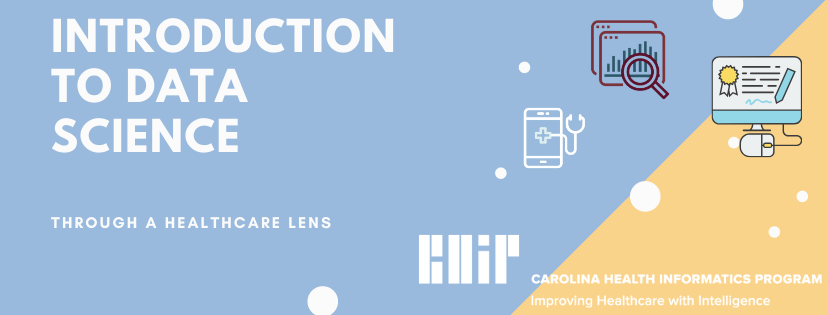

The Carolina Health Informatics Program (CHIP) has developed a few online training modules called An Introduction to Data Science through a health care lens to expose learners to the field of data science.These online modules are accessible to anyone who is interested, and require no prior training or knowledge in data science. The modules include video lectures jupyter notebooks 
https://datamine.unc.edu/onlinetraining/